#  The Final Project for MATH-6205 by Rezvan Karaji, 202193612.

The chosen task for this project is **Sentiment Detection** of user reviews. This is a classification task that encodes words in a text with Natural Language Processing techniques, and predicts their sentiment to be positive or negative. Three different deep approaches are applied to a same corpus, and their performance is compared at the end. The website of [Computational Linguistics from NTNU](https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/intro.html) is the primary reference and inspiration for this project.

#  Dependencies

In [1]:
!pip install transformers
!pip install datasets
!pip install kaggle

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 17.2 MB/s 
     |████████████████████████████████| 895 kB 36.1 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 40.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 32.0 MB/s 
     |████████████████████████████████| 1.1 MB 49.6 MB/s 
     |████████████████████████████████| 136 kB 49.9 MB/s 
     |████████████████████████████████| 127 kB 54.4 MB/s 
     |████████████████████████████████| 271 kB 54.3 MB/s 
     |████████████████████████████████| 94 kB 1.3 MB/s 
     |████████████████████████████████| 144 kB 54.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib

In [2]:
import time
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow
import tensorflow.keras as keras
import keras.backend as K
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Activation, Input, LSTM, Embedding, Layer

import transformers
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

from datasets import Dataset

seed = 41

# Data

The data for this project is **Sentiment Labelled Sentences Data Set** from Kaggle, which you can find [here](https://www.kaggle.com/datasets/marklvl/sentiment-labelled-sentences-data-set).

This dataset was created for the Paper [From Group to Individual Labels using Deep Features, Kotzias et. al,. KDD 2015](https://doi.org/10.1145/2783258.2783380).

It contains review sentences from **Amazon**, **Yelp**, and **IMDB** websites, which are labelled with a positive(1) or negative(0) sentiment scores. 

To automatically download the dataset from kaggle, follow these steps:
*   Download your Kaggle API Token by Going to your Account and scroll down to the API section. By clicking “Create New API Token”, a kaggle.json file will be generated and downloaded to your local machine.
*   Upload kaggle.json to your Colab project.
*   Run the following cell:

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = './' #  path to the current working directory
!kaggle datasets download -d marklvl/sentiment-labelled-sentences-data-set

  0% 0.00/326k [00:00<?, ?B/s]
100% 326k/326k [00:00<00:00, 75.4MB/s]


##  Load Data

In [4]:
file_name = 'sentiment-labelled-sentences-data-set.zip'
zf = zipfile.ZipFile(file_name) 
zf.namelist() 

['sentiment labelled sentences/amazon_cells_labelled.csv',
 'sentiment labelled sentences/amazon_cells_labelled.txt',
 'sentiment labelled sentences/imdb_labelled.csv',
 'sentiment labelled sentences/imdb_labelled.txt',
 'sentiment labelled sentences/readme.txt',
 'sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.csv',
 'sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt',
 'sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.csv',
 'sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt',
 'sentiment labelled sentences/sentiment labelled sentences/readme.txt',
 'sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.csv',
 'sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.txt',
 'sentiment labelled sentences/yelp_labelled.csv',
 'sentiment labelled sentences/yelp_labelled.txt']

The .txt files for amazon and yelp contain review sentences and their labelled sentiments, all of these files will be read and integrated, to create the dataset. I didn't use imdb, since it contains paragraph text data, and the length of text would be too different from two other sites.

In [5]:
data = []
for site in ['amazon_cells', 'yelp']:
  file_name = 'sentiment labelled sentences/sentiment labelled sentences/'+site+'_labelled.txt'
  df = pd.read_csv(zf.open(file_name), sep='\t', header=None, names=['text', 'label'])
  data.append(df)
data = pd.concat(data).reset_index(drop=True)
data

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
1995,I think food should have flavor and texture an...,0
1996,Appetite instantly gone.,0
1997,Overall I was not impressed and would not go b...,0
1998,"The whole experience was underwhelming, and I ...",0


The final data has 2k pairs of text and sentiment, without any missing values.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


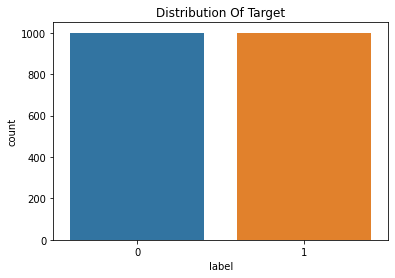

In [7]:
sns.countplot(data['label'])
plt.title("Distribution Of Target")
sns.set(rc={'figure.figsize':(6,4)})

The distribution of data in classes is balanced.

## Preprocess

The text data needs to be pre-processed, tokenized and encoded to numerical values, so I used the *Tokenizer()* of Keras, which performs all these steps. The *text_to_sequences()* method converts the text into sequences, and each sentence becomes one vector. The elements of the vectors are words of the sentence that has been encoded to unique integers. *text_matrix* keeps the encoded text data.

In [8]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data['text'])
encoded_text = tokenizer.texts_to_sequences(data['text'])
print(data.iloc[0, 0], '\n', encoded_text[0]) # first sentence in data and its encoded version

So there is no way for me to plug it in here in the US unless I go by a converter. 
 [27, 58, 7, 55, 141, 12, 60, 6, 268, 5, 14, 45, 14, 1, 148, 448, 3, 59, 112, 4, 1427]


*tokenizer.index_word* returns a dictionary where keys are integers, and the values are corresponding vocabulary words. So the length of this dictionary gives the number of words in our vocabulary.

In [9]:
vocab_size = len(tokenizer.index_word)
vocab_size

3258

The post padding technique is used to make all the vectors the same size. Zeros will be added at the end of the vectors until their length equals the maximum length of sentences. This number is the number of features for each sample.

In [10]:
feature_size = max([len(vector) for vector in encoded_text])
encoded_text = pad_sequences(encoded_text, maxlen=feature_size, padding='post')

We attach each sample with its label again.

In [11]:
features = pd.DataFrame(encoded_text)
processed_data = pd.concat([features, data['label']], axis=1)
processed_data

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
0,27,58,7,55,141,12,60,6,268,5,...,0,0,0,0,0,0,0,0,0,0
1,17,109,86,396,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,18,12,1,730,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1428,6,164,12,731,967,89,73,968,124,...,0,0,0,0,0,0,0,0,0,0
4,1,605,7,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,121,24,296,22,246,2,882,2,201,...,0,0,0,0,0,0,0,0,0,0
1996,3252,3253,954,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,238,3,8,11,180,2,43,11,59,39,...,0,0,0,0,0,0,0,0,0,0
1998,1,643,139,8,1267,2,3,121,699,50,...,0,0,0,0,0,0,0,0,0,0


The train and test data with the ratio of 9 to 1 is prepared. 

As mentioned before, the target value is the sentiment and the features are encoded text vectors.

Random state is defined to ensure reproducibility.

In [12]:
train, test = train_test_split(processed_data, test_size=0.1, shuffle=True, random_state=seed)
X_train = train.drop(['label'], axis=1).to_numpy()
y_train = train['label'].to_numpy()
X_test = test.drop(['label'], axis=1).to_numpy()
y_test = test['label'].to_numpy()
print('size of train:', len(y_train), '\nsize of test:', len(y_test))

size of train: 1800 
size of test: 200


#  Befor Training models

Define Callback function to obtain train-time of the models, [sorce](https://stackoverflow.com/questions/68877995/how-would-i-measure-record-the-total-training-time-for-an-artificial-neural-netw)

In [13]:
class TRA(keras.callbacks.Callback):
  def __init__(self):
      super(TRA, self).__init__()
  
  def on_train_begin(self, logs=None):
      self.start_time= time.time()
      
  def on_train_end(self, logs=None):
      stop_time=time.time()
      tr_duration= stop_time- self.start_time            
      minutes = (tr_duration) // 60
      seconds = tr_duration - (minutes * 60)
      msg = f'training elapsed time was {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
      print(msg) 
callbacks=[TRA()]

In [14]:
reports = {}

#  LSTM

The first approach is using LSTM as a baseline model.

The first layer is an Embedding layer that takes the 32-dimensional vectors(encoded sentences). The output of this layer is a 32x32 dimensional matrix.
The next layer is an LSTM layer with 100 neurons. The output is the hidden states of the LSTM, 100-dimensional vectors. The choice of hyperparameters are set to default to satisfy CUDNN, which accelerates the lstm. The output is passed to a Dense layer with **sigmoid** activation. The model is compiled using the **Adam** optimizer and **binary cross-entropy** loss function.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 32)            104288    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 157,589
Trainable params: 157,589
Non-trainable params: 0
_________________________________________________________________


None

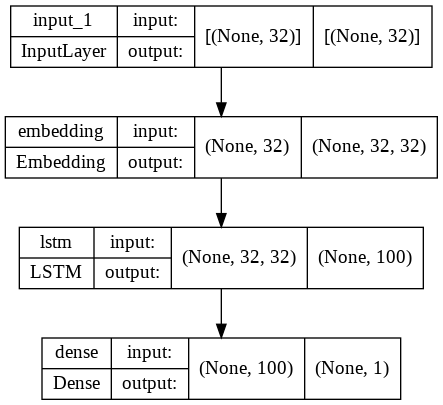

In [15]:
inputs = Input(shape=(feature_size,))
x = Embedding(input_dim = vocab_size + 1,
              output_dim = feature_size,
              input_length = feature_size,
              embeddings_regularizer=keras.regularizers.l2(0.001))(inputs)
x = LSTM(100)(x)
outputs = Dense(1, activation='sigmoid',trainable=True)(x)
model_1 = Model(inputs,outputs)
model_1.compile(optimizer='adam', loss='binary_crossentropy')

display(model_1.summary(), keras.utils.plot_model(model_1, show_shapes=True))

In [16]:
history = model_1.fit(x=X_train, y=y_train, batch_size=8, epochs=10, validation_data=(X_test, y_test), workers=-1, verbose=0, callbacks=callbacks)

training elapsed time was  0.0 minutes, 36.05 seconds)


Performance of model through epochs.

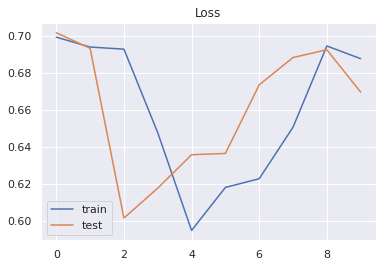

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Classification report of the model

In [18]:
probas = model_1.predict(X_test)
pred = (probas > 0.5).astype(int)
report = classification_report(y_test, pred)
reports['lstm'] = report
print(report)

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       106
           1       1.00      0.09      0.16        94

    accuracy                           0.57       200
   macro avg       0.78      0.54      0.43       200
weighted avg       0.76      0.57      0.45       200



#  LSTM + simple Bahdanau Attention layer

LSTM works with stacked unites as encoder and decoder. The encoder LSTM processes the entire input sentence and encodes it into a context vector, which is the last hidden state of the LSTM and is expected to be a good summary of the input sentence. All the intermediate states of the encoder are ignored, and the final state is supposed to be the initial hidden state of the decoder. Then the decoder LSTM units produce the words in a sentence one after another.
The main drawback of this approach is that If the encoder makes a bad summary, the translation will also be bad. And it has been observed that the encoder creates a bad summary when it tries to understand longer sentences. It is called the long-range dependency problem of LSTMs. Another problem is that there is no way to give more importance to some of the input words than others while translating the sentence. 


**Attention Mechanism** selectively concentrates on a few relevant things while ignoring others in deep neural networks. The attention mechanism is proposed by  [Bahdanau et al. in 2015](https://doi.org/10.48550/arXiv.1409.0473), as an improvement over the encoder decoder-based neural machine translation system in natural language processing. Later, this mechanism, or its variants, was used in other applications. They suggested that not only can all the input words be taken into account in the context vector, but relative importance should also be given to each one of them. So, whenever the proposed model generates a sentence, it searches for a set of positions in the encoder hidden states where the most relevant information is available.


To implement a simple attention layer, its class will inherit from the default Layer class in Keras.
*  build(): The weights and biases are defined.
*  call(): An MLP should be implemented to perform the attention mechanism. The weights and biases, then tanh and softmax, would be applied on inputs to get alignment scores. Context vector is the dot product of inputs, and this scores, which retrieves information from hidden states of the previous layer.

In [19]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), initializer='normal')
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), initializer='zeros')        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        output = x * alpha
        output = K.sum(output, axis=1)
        return output

Let's add this layer to our previous lstm. The parameters and layers are the same as before, only an attention layer is added between lstm and dense layers. *Notice: here we should set return_sequences=True in our LSTM layer because we want our LSTM to output all the hidden states.*

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 32, 32)            104288    
                                                                 
 lstm_1 (LSTM)               (None, 32, 100)           53200     
                                                                 
 attention (attention)       (None, 100)               132       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 157,721
Trainable params: 157,721
Non-trainable params: 0
_________________________________________________________________


None

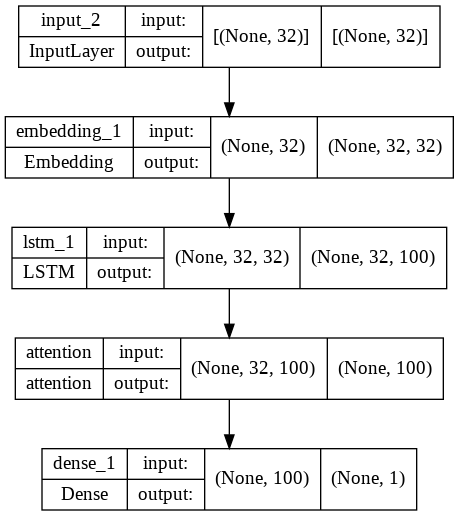

In [20]:
inputs = Input(shape=(feature_size,))
x = Embedding(input_dim = vocab_size + 1,
              output_dim = feature_size,
              input_length = feature_size,
              embeddings_regularizer=keras.regularizers.l2(.001))(inputs)
x = LSTM(100, return_sequences=True)(x)
x = attention()(x)
outputs = Dense(1, activation='sigmoid',trainable=True)(x)
model_2 = Model(inputs,outputs)
model_2.compile(optimizer='adam', loss='binary_crossentropy')

display(model_2.summary(), keras.utils.plot_model(model_2, show_shapes=True))

In [21]:
history = model_2.fit(x=X_train, y=y_train, batch_size=8, epochs=10, validation_data=(X_test, y_test), workers=-1, verbose=0, callbacks=callbacks)

training elapsed time was  0.0 minutes, 26.84 seconds)


Performance of model through epochs.

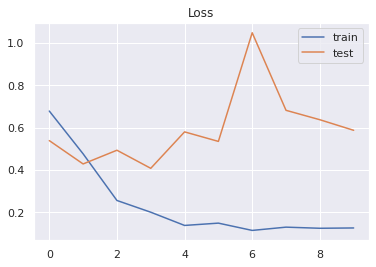

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Classification report of the model

In [23]:
probas = model_2.predict(X_test)
pred = (probas > 0.5).astype(int)
report = classification_report(y_test, pred)
reports['lstm_attn'] = report
print(report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       106
           1       0.86      0.82      0.84        94

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



#  Transfer Learning

A **transformer** is an architecture that builds upon self-attention layers. A transformer block combines the self-attention layer with a local feedforward network and adds normalization and residual connections. A transformer block can also have multiheaded attention layers to keep track of different types of long-distance relationships between input tokens. With the transformer blocks,  All we need to do to train a classifier is work out how to feed the input sequences into the architecture and how to transform the final output sequence into a single classification.

Transformers package from [**HuggingFace**](https://huggingface.co/) for pre-trained transformers-based language models is used here. HuggingFace Transformers provides APIs to download and train state-of-the-art pre-trained models easily. Using pre-trained models can reduce your compute costs and save you time from training a model from scratch. The chosen model is *bert-base-uncased*, which has 12-layer, 768-hidden, 12-heads, and 110M parameters. For more information, refer to Hugginface transformers' [BERT documentation](https://huggingface.co/docs/transformers/model_doc/bert). 

The next approach in this project is to use Transfer Learning to fine-tune a powerful language model, like **BERT**, on our data, so the deep methods can perform better, although the dataset is relatively small. Transfer Learning is the concept of learning a fundamental representation of the data that can be adapted to different tasks. The idea is to use transformers' architecture for re-trainability of deep models, which is basically to feed new data to the architecture of previously trained models and transform their final output to adjust to our problem. The learning of this fundamental general-purpose representation often relies on a large amount of data that are available relatively cheaply. Two important considerations for effective transfer learning:

1. The pre-training should be based on an abundant amount of data.

2.  The fine-tuning should be done with data that shares similarities with the data used for pre-training.


In [25]:
model_name = "bert-base-uncased"

First we should put our un-tokeized data in a Dataset type from HoggingFace. And split the data into train and test with ratio 9 to 1.

In [24]:
dataset = Dataset.from_pandas(data).train_test_split(test_size=0.1)

Based on second requirment, our data should be tokenized by the same tokenizer used for the BERT model *bert-base-uncased*.

In the cell below, the tokenizer is called and applied to the whole dataset.

In [26]:
tokenizer = BertTokenizer.from_pretrained(model_name)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The tokenized dataset looks like below, notice that extra features were extracted from text by the tokenizer, as they are needed in BERT model.

In [27]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
})

Now, we fetch the same bert model as out tokenizer to fine-tune on our data. BertForSequenceClassification is the module from HuggingFace that provides the classification models of bert. our data labels consist of two classes of possitive or negatice, so the number of labels should be 2.

In [28]:
model_3 = BertForSequenceClassification.from_pretrained(model_name, num_labels=2) 

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

I defined hyperparameters and built and fitted/fine-tuned the model on our data in the following cell using HuggingFace's trainer object. The best performing model will be saved in the directory. The loss function and batch size is as befor for comparison reasons.

In [29]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=seed,
    load_best_model_at_end=True,)
trainer = Trainer(
    model=model_3,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],)
 
# Train pre-trained model
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1800
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 675


Step,Training Loss,Validation Loss
500,0.206200,0.267684


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output/checkpoint-500 (score: 0.2676840126514435).


TrainOutput(global_step=675, training_loss=0.1585211573706733, metrics={'train_runtime': 980.8605, 'train_samples_per_second': 5.505, 'train_steps_per_second': 0.688, 'total_flos': 1420799698944000.0, 'train_loss': 0.1585211573706733, 'epoch': 3.0})

The best model is saved, so we load it again to do prediction on test data. The raw predictions contain a two dimentional array for each sample, representing the confidence and probability of each class. Notice that the tokenized test data should be passed to the model.

In [30]:
# Load trained model
model_path = "output/checkpoint-500"
model_3 = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model_3)

# Make prediction
raw_pred, _, _ = test_trainer.predict(tokenized_datasets['test'])

loading configuration file output/checkpoint-500/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file output/checkpoint-500/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceCla

By np.argmax() for each sample the most confident class is found and the prediction classes are obtained. Then the classification report on the performance of model is shown below.

In [31]:
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.array(tokenized_datasets['test']['label'])

report = classification_report(y_true, y_pred)
reports['bert_transfer'] = report
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       102
           1       0.95      0.95      0.95        98

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



#  Conclusion

The optimizer, loss function and batch sizes are kept the same for all three methods for the sake of comparison.

In [32]:
for name, report in reports.items():
  print(name, '\n', report)
  print('-----------------------------------------------------------')

lstm 
               precision    recall  f1-score   support

           0       0.55      1.00      0.71       106
           1       1.00      0.09      0.16        94

    accuracy                           0.57       200
   macro avg       0.78      0.54      0.43       200
weighted avg       0.76      0.57      0.45       200

-----------------------------------------------------------
lstm_attn 
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       106
           1       0.86      0.82      0.84        94

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200

-----------------------------------------------------------
bert_transfer 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       102
           1       0.95      0.95      0.95        98

    accuracy               

As expected, after adding the attention layer, the performance of the lstm model improves. Because the attention layer considers the context information from hidden layers of lstm, both models were trained in less than a minute using GPU. However, the small size of the dataset prevents an accuracy of more than 86 percent. Therefore the third method is using transer learning and fine-tune the Bert language model on our data. By this technique, the language and relation recognition strengths of Bert is transfered to our model, so the model doesn't need too much data to learn and predict the labels accuratly, in only about 15 minutes of training time. and as you can see, the accuracy of the model increased to 95 precent. Also the precision and recalls balanced between classes after the regular lstm model. The small amount of data could cause disbalance when deviding and batching data, but this problem is not evident using attention mechanisms.